<a href="https://colab.research.google.com/github/amalazimroshan/micrograd/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

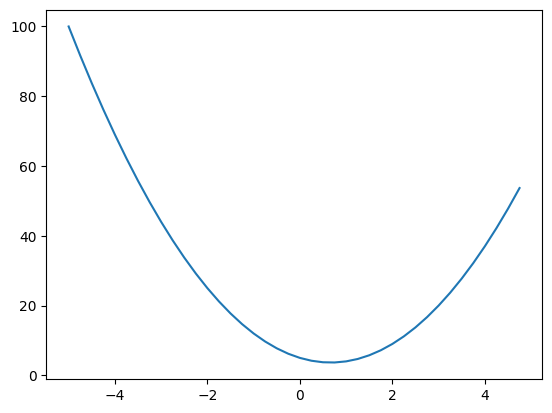

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [ ]:
h = 0.0001
x = 2/3
(f(x + h) - f(x))/h

0.0002999999981767587

In [ ]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
c += h
d2 = a*b + c
print('d1',d1)
print('d2',d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
class Value:

  def __init__(self,data, _children=(),_op='',label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value({self.data})"

  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data,(self,other),'+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data * other.data,(self,other),'*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self,other):
    return self * other

  def __neg__(self):
    return self * -1

  def __sub__(self,other):
    return self + (-other)

  def __rsub__(self,other):
    return other + (-self)

  def __radd__(self,other):
    return self + other

  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
    out = Value(t,(self,),'tanh')
    def _backward():
      self.grad += (1-t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x),(self,),'exp')
    def _backward():
      self.grad += out.data * out.grad  #out.grad is multiplied as a part of chain rule and o
                                        #out.data is the local derivative of e^x
    out._backward = _backward
    return out

  def __pow__(self,other):
    assert isinstance(other,(int,float)), "only supporting int/float powers for now"
    out = Value(self.data**other,(self,),f'**{other}')
    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out

  def __truediv__(self,other):
    return self * other**-1

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


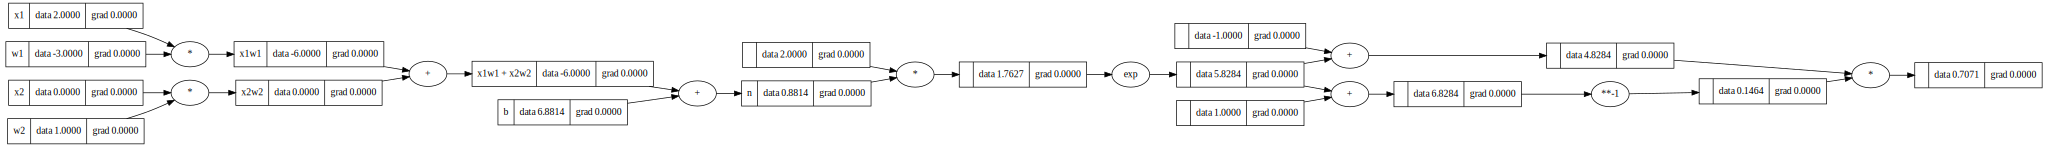

In [ ]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
b = Value(6.8813735870195432,label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# o = n.tanh(); o.label = 'o'
e = (2*n).exp()
o = (e - 1)/(e + 1)
draw_dot(o)

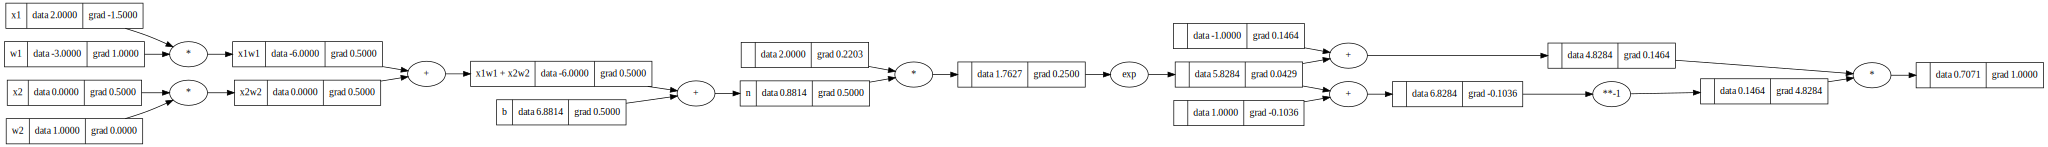

In [ ]:
o.backward()
draw_dot(o)

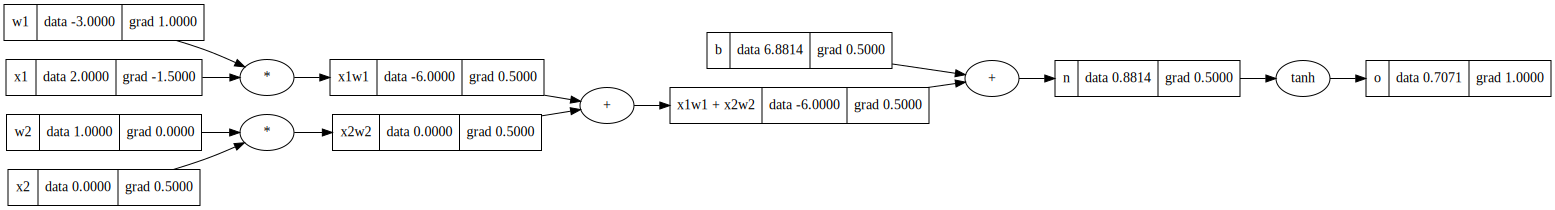

In [ ]:
o.backward()
draw_dot(o)

In [ ]:
import torch

x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True

b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

In [ ]:
print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
import random

In [ ]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w,x)),self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self,nin,nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self,nin,nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(-0.5749950190744362)

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [ ]:
ypred = [n(x) for x in xs]
print(ypred)
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))
print(loss)

[Value(0.5204853035235018), Value(0.1843240906330367), Value(0.2612522926129056), Value(0.3628998696654306)]
Value(3.6292118174843537)


In [ ]:
loss.backward()

In [ ]:
n.layers[0].neurons[0].w[0].data

0.7378803805271011

In [ ]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [ ]:
for k in range(20):
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  for p in n.parameters():
    p.data += -0.01 * p.grad

  print(k, loss.data)

0 6.113997489555922e-05
1 6.113419051550076e-05
2 6.112840742858428e-05
3 6.112262563434971e-05
4 6.111684513233928e-05
5 6.111106592209202e-05
6 6.110528800314959e-05
7 6.109951137505259e-05
8 6.109373603734324e-05
9 6.108796198956335e-05
10 6.108218923125322e-05
11 6.107641776195559e-05
12 6.107064758121333e-05
13 6.106487868856903e-05
14 6.105911108356501e-05
15 6.105334476574269e-05
16 6.104757973464877e-05
17 6.104181598982371e-05
18 6.103605353081036e-05
19 6.103029235715547e-05


In [ ]:
ypred

[Value(0.9936522657380437),
 Value(-0.9999440617636767),
 Value(-0.9999104620379338),
 Value(0.9954474824587041)]